# Simple model I

__Model:__ A simple CNN adapted from the MNIST example available at [Mnist tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb)

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Get dataset

In [ ]:
# Authenticate to GCS.

from google.colab import auth
auth.authenticate_user()

# Copy data set files
!test -f dataset.zip || gsutil cp gs://onboard_image_dataset/dataset.zip .
!unzip -q -o dataset.zip

Copying gs://onboard_image_dataset/dataset.zip...
| [1 files][183.3 MiB/183.3 MiB]                                                
Operation completed over 1 objects/183.3 MiB.                                    


## Define train, validation and test sets

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_dataset = datagen.flow_from_directory(
    'dataset/train',
    target_size=(64,64),
    class_mode='sparse'
)
validation_dataset = datagen.flow_from_directory(
    'dataset/validation',
    target_size=(64,64),
    class_mode='sparse'
)
test_dataset = datagen.flow_from_directory(
    'dataset/test',
    target_size=(64,64),
    class_mode='sparse'
)

Found 630 images belonging to 3 classes.
Found 135 images belonging to 3 classes.
Found 135 images belonging to 3 classes.



## Define CNN using Keras API


In [ ]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1572992   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,573,379
Trainable params: 1,573,379
Non-trainable params: 0
_________________________________________________________________


## Train model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

max_epochs = 50

history = model.fit(
     train_dataset,
     epochs=max_epochs,
     validation_data=validation_dataset,
     callbacks=[stop_early]
)

Epoch 1/50
20/20 [==============================] - 17s 753ms/step - loss: 3.1853 - accuracy: 0.3492 - val_loss: 1.1692 - val_accuracy: 0.3333
Epoch 2/50
20/20 [==============================] - 15s 748ms/step - loss: 1.1575 - accuracy: 0.4698 - val_loss: 0.9699 - val_accuracy: 0.5630
Epoch 3/50
20/20 [==============================] - 15s 735ms/step - loss: 0.9584 - accuracy: 0.5397 - val_loss: 0.8592 - val_accuracy: 0.6593
Epoch 4/50
20/20 [==============================] - 15s 737ms/step - loss: 0.8331 - accuracy: 0.6381 - val_loss: 0.8520 - val_accuracy: 0.6667
Epoch 5/50
20/20 [==============================] - 15s 731ms/step - loss: 0.8298 - accuracy: 0.5984 - val_loss: 0.8083 - val_accuracy: 0.6370
Epoch 6/50
20/20 [==============================] - 15s 737ms/step - loss: 0.7861 - accuracy: 0.6476 - val_loss: 0.8210 - val_accuracy: 0.6741
Epoch 7/50
20/20 [==============================] - 15s 738ms/step - loss: 0.8038 - accuracy: 0.6190 - val_loss: 0.8022 - val_accuracy: 0.6370

## Plot training evolution

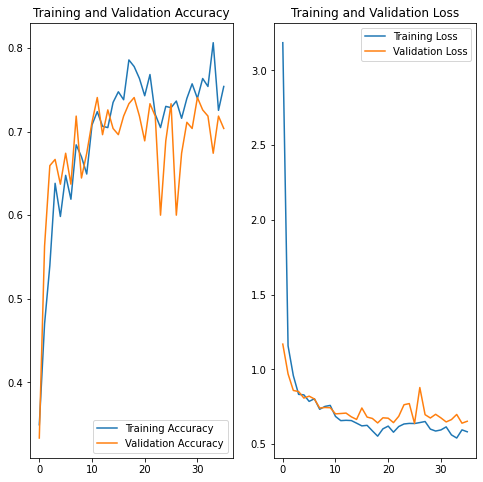

In [ ]:
from  matplotlib import pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Save model and convert it to TFLite format

In [ ]:
model.save('mnist')
converter = tf.lite.TFLiteConverter.from_saved_model('mnist') # path to the SavedModel directory
tflite_model = converter.convert()
with open('mnist.tflite', 'wb') as f:
      f.write(tflite_model)

INFO:tensorflow:Assets written to: mnist/assets


## Calculate accuracy and loss for test dataset

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)

print("VALIDATION - loss {}, accuracy {}".format(loss,accuracy))

loss, accuracy = model.evaluate(test_dataset)

print("TEST - loss {}, accuracy {}".format(loss,accuracy))

5/5 [==============================] - 3s 497ms/step - loss: 0.6387 - accuracy: 0.7333
VALIDATION - loss 0.638741672039032, accuracy 0.7333333492279053
5/5 [==============================] - 3s 492ms/step - loss: 0.5861 - accuracy: 0.8000
TEST - loss 0.5860760807991028, accuracy 0.800000011920929
